<a href="https://colab.research.google.com/github/MichalMichniak/Sieci-Neuronowe/blob/main/agh_ai_days_rl_intro_k_armed_bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-armed bandtis

In this hands-on part of the workshops we will explore the simplest environment in terms of mathematical formulation: K-armed bandit.

Only one state, multiple discrete actions, different rewards distributions.

Let's try to solve this problem!

<img src="https://lh7-eu.googleusercontent.com/KzmEwcpY9we0aaDuKl9pZEpgut4kK3BRxYACxfJTDuXkrjOL36sxBQqWBgAMUn3cScNyVJnJJrlP_rKaUPKt-uuQPDAMv11z1RxuV12i_NMMhrLsp-21Apfvuyp-RaWB0moaBNoH6E1enoe5MxPhVsk" alt="drawing" width="600px"/>

## Credits
- This notebook is **heavily based** (i.e. large portions of text and code have been copied) on the work by juanmadlg ( https://github.com/juanmadlg/K-armed-Bandit-Problem/tree/main )
- Maciej Aleksandrowicz for AGH AI Days 2024

## Packages

You will use the following packages in this assignment.

- [numpy](www.numpy.org) : Fundamental package for scientific computing with Python.
- [jdc](https://alexhagen.github.io/jdc/) : Jupyter magic that allows defining classes over multiple jupyter notebook cells.
- [tqdm](https://tqdm.github.io/) : A package to display progress bar when running experiments.
- [matplotlib](http://matplotlib.org) : Library for plotting graphs in Python.
- [scipy](https://scipy.org/) : Library for scientific tools, i.e. statistics.


In [201]:
!pip install jdc

In [202]:
import numpy as np
import jdc
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

# For reproducibility
np.random.seed(44)

## The main ideas:

1. The Bandit have `k` arms.
2. Each of the arm can return different values (sampled from distribution).
3. The number of arms and the underlying distributions are constans.
4. **We would like to somehow model the Bandit**.


## K-Armed Bandit Class

Let's introduce a class for holding data and methods related to the Bandit model.

These are the elements included in the K-Armed Bandit Class.

**Environment defition**:
* `k`: The number of arms.
* `A`: Vector of size `k`; stores the *mean value of the reward normal distribution* for every arm. In our case it is identical with $Q^*$ function. Initializated each time when the `reset()` is executed.
* `arms_mean`: Reference mean value for drawing numbers for the `A` vector.
* `standard_deviation`: It is used in two cases:
  * To generate the random values in the $A$ vector.
  * To generate the random reward of an arm when it is executed.

**Values for the decision making policy**:
* `N`: Vector of size `k`; counts how many times each lever has been selected.
* `Q`: Vector of size `k`; stores the Value-State function $Q$ for each arm (must be trained).
* `e`: Epsilon (chance) for selecting a random action.



### Importat notes about the notation
* The $Q$ function is something which needs to be discovered.
* The $Q^*$ is the optimal solution - here, the underlying mathematical model of the rewards.
* The $Q$ function is always seen with two parameters: `s` state and `a` action: $Q(s,a)$.
  * For this scenario there is **only one** state, so it can be simplified to $Q(a)$. However, when it is important to distinguish such function for particular state, another notation can be used: $V(a)$.

In [203]:
class k_armed_bandit:
  def __init__(self, configuration):
    '''
    Configuration is a dictionary that includes all diferente required settings
    Here: {
      "k": <number_of_arms>,
      "e": <chance_for_random_action>,
      "arms_mean": <reference_mean_value_for_reward_initalization>,
      "std_dev": <standard_deviation_used_for_normal_distributions>
      }
    '''
    # Math model of the k-armed bandit
    self.A = None # here, it's identical to the Q* function
    self.k = configuration['k']

    # Variables for the algorithm
    self.N = None # counts lever selections
    self.Q = None # estimation of the Q* function
    self.e = configuration['e']

    # Simplified utility variables
    self.arms_reference_mean = configuration['arms_mean']
    self.standard_deviation = configuration['std_dev']

  def reset(self):
    '''
    Reset is executed at the begining of each episode. It sets to zero Q and N
    and creates a new distribution of Q* (i.e. A) for the k arms.
    '''
    # ------------------------------------------------------------------------ #
    #TODO fill initalize vector Q, N and A (i.e. Q*)
    size = (self.k, ) #set the size
    self.Q = np.zeros(size) # initalize with zeros
    self.N = np.zeros(size) # initalize with zeros
    self.A = np.random.normal(loc=self.arms_reference_mean, scale=self.standard_deviation, size=(self.k, ))
    # ------------------------------------------------------------------------ #

### A tactic for acting

We need to do something - select a lever. But:
1. Which lever?
2. How often to change the selected lever?

The thing for selecting an action is called as a ***policy*** - a function which takes the current state and returns an action:
$$
\pi_{\text{policy}}(s_\text{state}) = a_\text{action}
$$

The simplest way to balance *exploration* for information and *exploitation* of the current knowledge is to roll a dice and select between two options:
- *be optimal*,
- *do something new*.

<img src="https://resin-expert.com/wp-content/uploads/2020/11/resin-dice.jpg" alt="drawing" width="500px"/>

This method is called:

### Episilon-greedy action selection

$$
\DeclareMathOperator*{\argmax}{argmax}
a_\text{action} = \cases{ \underset{a}{\mathrm{argmax}}\, Q(a) & \text{with probability $1 - ϵ$}\\
a \sim U(\{a_1, \dots, a_n\}) & \text{with probability $ϵ$}
}
$$

Let's implement these equations in the `k_armed_bandit` class to obtain an action:



In [204]:
%%add_to k_armed_bandit

def get_action(self):
  '''
  €-greedy action selection: exploration vs. exploitation
  '''
  # -------------------------------------------------------------------------- #
  #TODO implement
  '''
  TODO implmenet, using:
  random_action = np.random.randint(<int_value>)
  maximum_estimated_value = np.argmax(<vector>)
  '''
  epsilon = self.e
  random_value = np.random.random_sample()

  # Exploration, random arm from k-arms

  if random_value<epsilon:
    return np.random.randint(self.k)
  return np.argmax(self.Q)
  # -------------------------------------------------------------------------- #
  #  return ...

  # Exploitation, select the lever with the highest know reward

  # return ....
  # -------------------------------------------------------------------------- #

### Use an action on the Bandit

We can generate an action, but we need somehow to use it on the environment (the Bandit).

Let's introduce another class method:

Return a random value (the reward) based on a normal distribution with $Q^*(\text{arm})$ (i.e. $A(\text{arm})$) as mean and the standard deviation.

In [205]:
%%add_to k_armed_bandit

def bandit_step(self, action):
  '''
  Gets value of the selected arm based on a normal distribution with Q*(action) (here: A(action)) as the mean
  '''
  # -------------------------------------------------------------------------- #
  #TODO write the reward function
  # reward = np.random.normal(None, None)
  reward = np.random.normal(self.A[action], self.standard_deviation )
  # -------------------------------------------------------------------------- #
  return reward

### Training the Q estimator

Now, it's time to train the $Q$ function estimation (i.e. the function which will predict the best return value) with ***ϵ-greedy policy***.

For each (time) step of the algorithm:
1. Get the action (select an arm) (ϵ-greedy action selection),
2. Act on bandit, obtain a $r$ reward for that arm,
3. Increment the counter of arm selection,
4. Calculate the value function for the arm with the update function:

$$
Q_{n+1}(a) = Q_n(a) + (r_n - Q_n(a)) / n
$$

In addition, we would like to log the actions trajectory (the history of actions).

In [206]:
%%add_to k_armed_bandit

def exec(self, steps):
  rewards = []
  trajectory = []

  for i in range(steps):
    # ------------------------------------------------------------------------ #
    #TODO: Get action & act on the bandit
    a = self.get_action()
    r = self.bandit_step(a)
    # ------------------------------------------------------------------------ #

    self.N[a] += 1
    # ------------------------------------------------------------------------ #
    #TODO: implement the Update Value Function Q(a)
    self.Q[a] = self.Q[a] + (r - self.Q[a])/self.N[a] #...
    # ------------------------------------------------------------------------ #

    rewards.append(r)
    trajectory.append(a)

  return rewards, trajectory

## Evaluate the Rewards

### First Scenario

* **Arms**: 10 (k)
* **Epislon**: 0.1
* **Steps**: 800
* **Mean**: 1
* **Standard deviation**: 1
* **Steps**: 800

In [207]:
# ---------------------------------------------------------------------------- #
#TODO: Enter the values
configuration = {
    'k': 10,
    'e': 0.1,
    'arms_mean': 1,
    'std_dev': 1
}
steps = 800
# ---------------------------------------------------------------------------- #

In [208]:
# ---------------------------------------------------------------------------- #
# TODO: Create the bandit, with configuration and obtain the rewards
bandit_env = k_armed_bandit(configuration)
bandit_env.reset()
rewards, trajectory = bandit_env.exec(steps)
# ---------------------------------------------------------------------------- #

Let's visualize the rewards, actions and the trained $Q$:

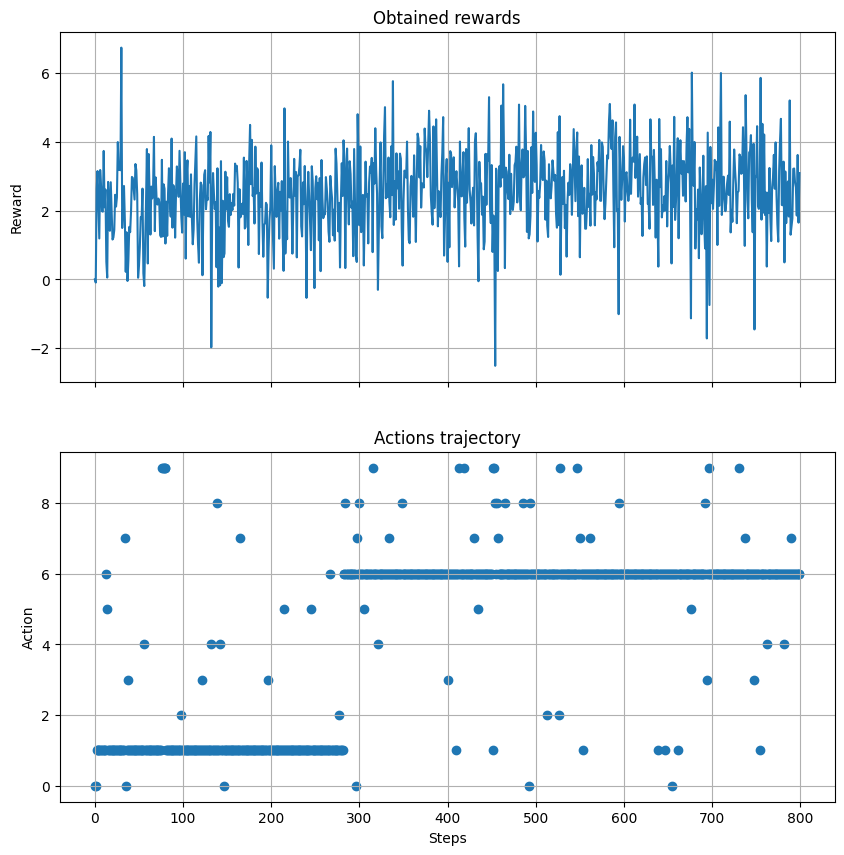

In [209]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

f.set_figheight(10)
f.set_figwidth(10)

# ---------------------------------------------------------------------------- #
# TODO: plot, where x=number of steps, y=rewards
ax1.plot(np.arange(steps), rewards)

# ---------------------------------------------------------------------------- #

ax1.set_ylabel("Reward")
ax1.set_title("Obtained rewards")
ax1.grid(True)

# ---------------------------------------------------------------------------- #
# TODO: plot points, where x=step number, y=action in current step
ax2.scatter(np.arange(steps), trajectory)

# ---------------------------------------------------------------------------- #

ax2.set_title("Actions trajectory")
ax2.set_ylabel("Action")
ax2.grid(True)

ax2.set_xlabel("Steps")
f.show()

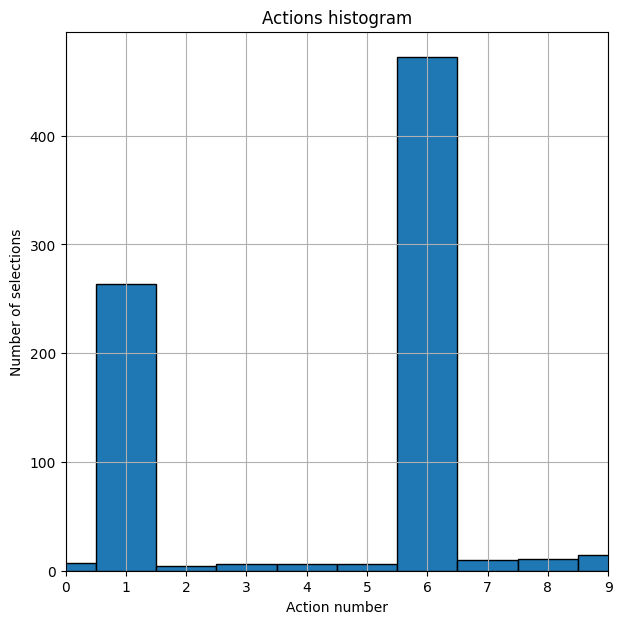

In [210]:
# Help values for setting up histograms (based on https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib)

d = 1
min_value = 0
max_value = configuration["k"] - 1
left_of_first_bin = min_value - float(d)/2
right_of_last_bin = max_value + float(d)/2
bins = np.arange(left_of_first_bin, right_of_last_bin + d, d)

f, ax = plt.subplots(1, 1)

f.set_figheight(7)
f.set_figwidth(7)

ax.set_xlim([min_value, max_value])

# ---------------------------------------------------------------------------- #
# TODO: Create a histogram of trajectory
ax.hist(trajectory, bins=bins, edgecolor = "black")

# ---------------------------------------------------------------------------- #

ax.set_xlabel("Action number")
ax.set_ylabel("Number of selections")
ax.set_title("Actions histogram")
ax.grid(True)

f.show()

The difference between Q* and Q:
 [-0.19584214  0.02052442  0.44625059 -0.08715535 -0.17449925 -0.7790406
 -0.04043397 -0.17449592  0.24426154 -0.12296954]


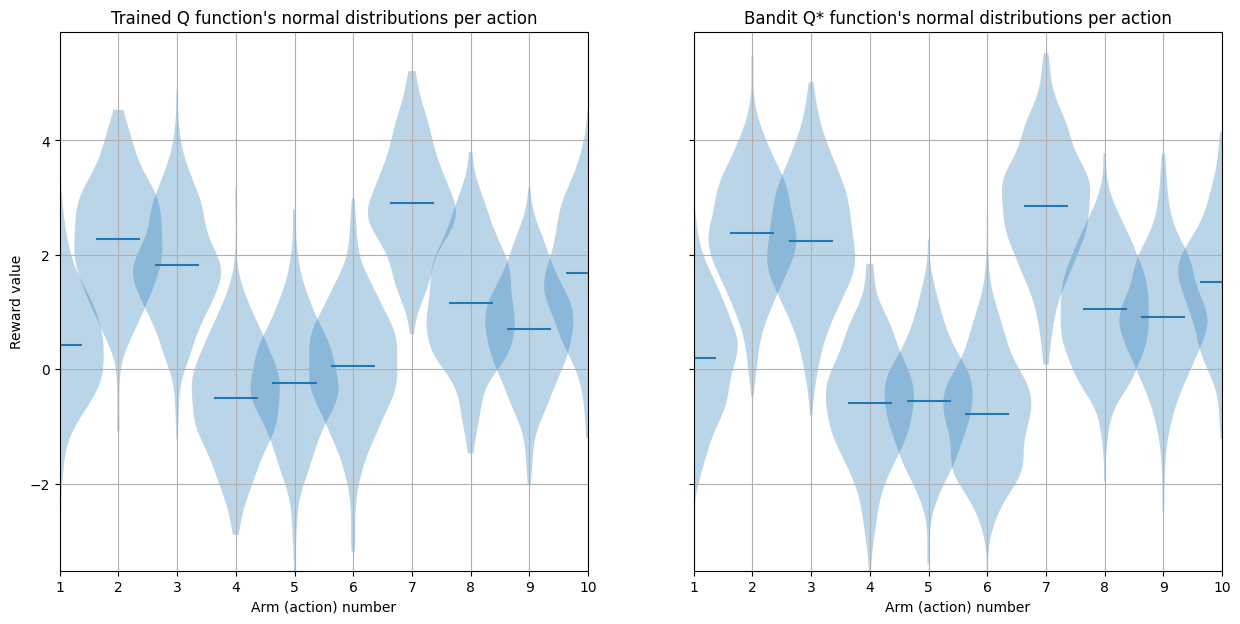

In [211]:
# Compare Q with Q*
size = bandit_env.k
Q = bandit_env.Q
Q_optimal = bandit_env.A
std_dev = bandit_env.standard_deviation

print(f"The difference between Q* and Q:\n {Q_optimal - Q}")

data_Q = np.random.normal(Q, np.ones(size) * std_dev, (300, size))
data_Q_optimal = np.random.normal(Q_optimal, np.ones(size) * std_dev, (300, size))

fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(15)

ax[0].violinplot(data_Q, widths=1.5,
                 showmeans=True, showmedians=False, showextrema=False)
ax[0].set_xlim(1, size)
ax[0].set_xticks(np.arange(1, size+1, 1.0))
ax[0].set_ylim(min(Q) - 3 * std_dev, max(Q) + 3 * std_dev)
ax[0].set_xlabel("Arm (action) number")
ax[0].set_ylabel("Reward value")
ax[0].set_title("Trained Q function's normal distributions per action")
ax[0].grid()

ax[1].violinplot(data_Q_optimal, widths=1.5,
                 showmeans=True, showmedians=False, showextrema=False)
ax[1].set_xlim(1, size)
ax[1].set_xticks(np.arange(1, size+1, 1.0))
ax[1].set_xlabel("Arm (action) number")
ax[1].set_title("Bandit Q* function's normal distributions per action")
ax[1].grid()

plt.show()

## Evaluate different epsilon values

**The rewards curve is too noisy** - it's hard to draw a trend line.

We cannot evaluate the difference only with a single execution for each epsilon value - it will be too unreliable.

To evaluate the different values of the epsilon it is necessary to execute $N$ different runs an calculate the average for each step.


Let's define a function for such evaluation:

In [215]:
def evaluate(configuration, epsilon_values, steps, runs):
  all_rewards = []

  # Iterate for each of the given epsilon value
  for epsilon in epsilon_values:
    print(f"> Execution of {runs} runs with the epsilon {epsilon}")
    configuration['e'] = epsilon

    bandit_env = k_armed_bandit(configuration)
    epislon_rewards = np.zeros((steps, ))

    # Let's execute independent runs
    for _ in tqdm(range(runs)):
      # We reset the environement everytime - there is no sense in logging of the trajectories.

      # ---------------------------------------------------------------------- #
      # TODO: reset the environement, collect rewards
      bandit_env.reset()
      rewards, _ = bandit_env.exec(steps)
      # ---------------------------------------------------------------------- #

      # ---------------------------------------------------------------------- #

      epislon_rewards = np.add(epislon_rewards, rewards)

    # Average for each step
    all_rewards.append(epislon_rewards / runs)

  return all_rewards

Now, let's define some epsilon values. The notes are prepared for `[0.01, 0.1, 0.5]` but experiments can be performed with other values (between `0.0` and `1.0`). Set `runs` to $2000$ , other values should be set as in previous configuration.

In [218]:
# ---------------------------------------------------------------------------- #
# TODO: define configuration
epsilon_values = [0.01, 0.1, 0.5]
configuration = {
    'k': 10,
    'e': 0,
    'arms_mean': 1,
    'std_dev': 1
}
steps = 800
runs = 2000

# ---------------------------------------------------------------------------- #

rewards = evaluate(configuration, epsilon_values, steps, runs)

> Execution of 2000 runs with the epsilon 0.01


100%|██████████| 2000/2000 [00:10<00:00, 186.60it/s]


> Execution of 2000 runs with the epsilon 0.1


100%|██████████| 2000/2000 [00:11<00:00, 170.99it/s]


> Execution of 2000 runs with the epsilon 0.5


100%|██████████| 2000/2000 [00:13<00:00, 146.12it/s]


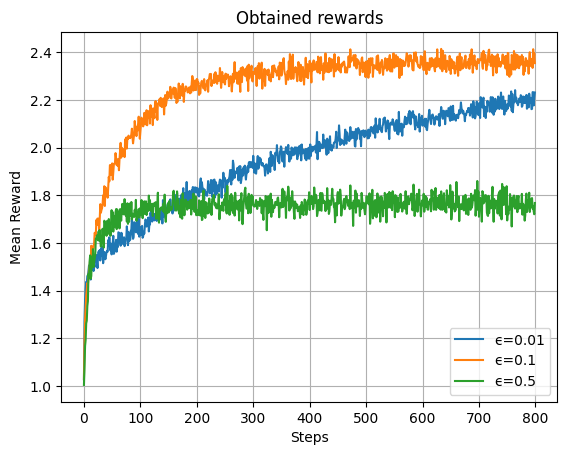

In [219]:
plt.figure()
plt.plot(range(steps), rewards[0], label="ϵ=0.01")
plt.plot(range(steps), rewards[1], label="ϵ=0.1")
plt.plot(range(steps), rewards[2], label="ϵ=0.5")
plt.xlabel("Steps")
plt.ylabel("Mean Reward")
plt.title("Obtained rewards")
plt.legend()
plt.grid(True)
plt.show()

**Conclusions**

We can see the different performances for the different epsilon values:

* **epsilon = 0.01**: In this case there is very little exploration and a lot of exploitation. This makes the average reward grow very little by little. What would happen if the number of steps is greater than 800?
* **epsilon = 0.1**: This seems to be the value of epsilon with better performance. It gets faster a good average reward and it maintains it. There is a good balance between exploration and exploitation for 800 Steps.
* **epsilon = 0.5**: In this case, we can see clearly that there is too much exploration. The result is clearly the worst when you explore/exploit the 50% of the time.

### Evaluate more Steps

Let's evaluate the same epsilon values with more steps. Will epsilon 0.01 be better than 0.1 in the long term?

In [222]:
# ---------------------------------------------------------------------------- #
# TODO: copy & paste previous configuration with epislon_values experiment,
# set steps to a greater value (for instance: 2000)
epsilon_values = [0.01, 0.1, 0.5]
configuration = {
    'k': 10,
    'e': 0,
    'arms_mean': 1,
    'std_dev': 1
}
steps = 4000
runs = 2000


# ---------------------------------------------------------------------------- #

rewards = evaluate(configuration, epsilon_values, steps, runs)

> Execution of 2000 runs with the epsilon 0.01


100%|██████████| 2000/2000 [00:53<00:00, 37.57it/s]


> Execution of 2000 runs with the epsilon 0.1


100%|██████████| 2000/2000 [00:53<00:00, 37.12it/s]


> Execution of 2000 runs with the epsilon 0.5


100%|██████████| 2000/2000 [01:02<00:00, 31.89it/s]


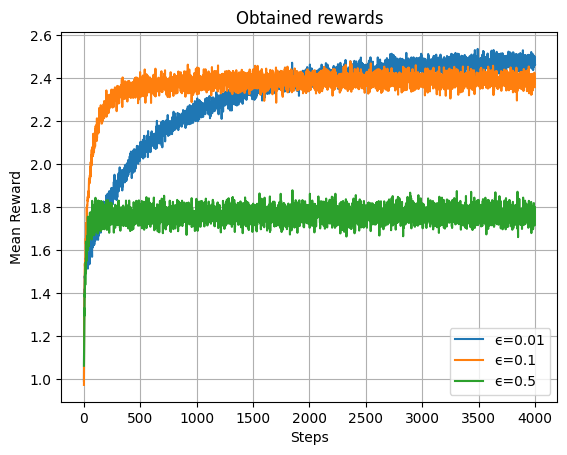

In [223]:
plt.figure()
plt.plot(range(steps), rewards[0], label="ϵ=0.01")
plt.plot(range(steps), rewards[1], label="ϵ=0.1")
plt.plot(range(steps), rewards[2], label="ϵ=0.5")
plt.xlabel("Steps")
plt.ylabel("Mean Reward")
plt.title("Obtained rewards")
plt.legend()
plt.grid(True)
plt.show()

**Conclusion**

Finally, it seems that $0.01$ and $0.1$ epsilon values converge to the same average reward.


**Which of them is better? Why?**